In [9]:
import sys
import pandas as pd
from pathlib import Path
import toml

sys.path.append('./abetam')

from abetam.data.canada import electricity_prices

config = toml.load('copper/scenarios/BAU_scenario/config.toml')

electricity_prices.head()

,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
REF_DATE,,,,,,,,,,,,,,
2000,8.402978,6.516774,10.105829,5.710638,7.342644,NaN,NaN,9.751083,NaN,7.211406,9.030832,4.764065,10.126978,NaN
2001,8.419454,6.692903,10.433143,6.073404,7.240460,NaN,NaN,9.561188,NaN,7.735599,9.388489,4.699748,11.074268,NaN
2002,8.238213,6.774194,10.228571,5.851064,7.298851,NaN,NaN,9.494725,NaN,7.488479,8.941418,4.594084,11.277259,NaN
2003,9.819950,7.221290,11.036629,6.137766,7.773276,NaN,NaN,10.235314,NaN,8.117512,9.942857,4.832977,11.920062,NaN
2004,10.198908,7.736129,11.783314,6.576596,8.349885,NaN,NaN,11.042365,NaN,8.641705,10.801233,5.218880,12.641807,NaN


In [10]:
def add_province(df):
    if "province" in df.columns:
        return df
    else:
        df.reset_index(inplace=True)
        df["province"] = df["node"].str.split(".", expand=True)[0]
        return df


copper_result_dir = "copper/results/LastRun"
duals = pd.read_csv(f"{copper_result_dir}/duals.csv").set_index(
    ["year", "hour", "node"]
)

duals = add_province(duals)

run_day_key = "run_days_test"
n_days = len(config["Simulation_Settings"][run_day_key])
print(
    f"n_days: {n_days}, using {run_day_key}: {config['Simulation_Settings'][run_day_key]}"
)

mean_electricity_price = (
    duals.groupby(["year", "province"])["dual_price"].mean() * -n_days / 365
)
mean_electricity_price /= 10 # $/MWh -> c/kWh
mean_electricity_price

n_days: 1, using run_days_test: [2]


year  province
2025  Ontario     13.333921
2030  Ontario     11.758158
2035  Ontario      9.867423
2040  Ontario      8.102771
2045  Ontario      6.640926
2050  Ontario      0.000337
Name: dual_price, dtype: float64

In [11]:
el_price_copper = mean_electricity_price.to_frame().reset_index().pivot(index="year", columns="province", values="dual_price")
el_price_copper

province,Ontario
year,
2025,13.333921
2030,11.758158
2035,9.867423
2040,8.102771
2045,6.640926
2050,0.000337


In [12]:
el_price_path = "abetam/data/canada/ca_electricity_prices.csv"
el_prices_df = pd.read_csv(el_price_path).set_index("REF_DATE")
el_prices_df.head()

,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
REF_DATE,,,,,,,,,,,,,,
2000,8.402978,6.516774,10.105829,5.710638,7.342644,NaN,NaN,9.751083,NaN,7.211406,9.030832,4.764065,10.126978,NaN
2001,8.419454,6.692903,10.433143,6.073404,7.240460,NaN,NaN,9.561188,NaN,7.735599,9.388489,4.699748,11.074268,NaN
2002,8.238213,6.774194,10.228571,5.851064,7.298851,NaN,NaN,9.494725,NaN,7.488479,8.941418,4.594084,11.277259,NaN
2003,9.819950,7.221290,11.036629,6.137766,7.773276,NaN,NaN,10.235314,NaN,8.117512,9.942857,4.832977,11.920062,NaN
2004,10.198908,7.736129,11.783314,6.576596,8.349885,NaN,NaN,11.042365,NaN,8.641705,10.801233,5.218880,12.641807,NaN


In [1]:
import sys
sys.path.append("abetam")

from abetam.batch import BatchResult

from abetam.components.probability import beta_with_mode_at
best_tech_modes = {
    "Electric furnace": 0.788965,
    "Gas furnace": 0.388231,
    "Heat pump": 0.346424,
    "Oil furnace": 0.460226,
    "Wood or wood pellets furnace": 0.516056,
}
batch_parameters = {
        "N": [50],
        "province": ["Ontario"],
        "random_seed": list(range(42, 44)),
        "tech_attitude_dist_func": beta_with_mode_at,
        "tech_attitude_dist_params": [best_tech_modes],
        "start_year": 2020,
        "price_weight_mode": 0.875,
    }

BatchResult.get_results_dir(batch_parameters, force_rerun=True)


WindowsPath('c:/src/canadopt/abetam/results/master/85a295abbfc554f4867d13af9d78ac31_1')

In [2]:
result = BatchResult.from_parameters(batch_parameters, force_rerun=True)

results_dir=WindowsPath('c:/src/canadopt/abetam/results/master/85a295abbfc554f4867d13af9d78ac31_1') does not exist. Running model.


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


In [3]:
result.save()

WindowsPath('c:/src/canadopt/abetam/results/master/85a295abbfc554f4867d13af9d78ac31_1')

# Results of the coupled model

In [1]:
# retrieve ABM results
from pathlib import Path

abm_result_dirs = list(Path("abetam/results/master").glob("*_[0-9]"))
n_results = int(abm_result_dirs[-1].as_posix()[-1])

In [2]:
# there is no guarantee for the coherence of these directories with the abm result directories
copper_result_dirs = list(Path("copper/results").glob("*"))[-(n_results+2):-1]
dict(zip(abm_result_dirs, copper_result_dirs))

{WindowsPath('abetam/results/master/e499e274edcb04f6ad5fecf6c84bcf86_0'): WindowsPath('copper/results/BAU_scenario_20240105_1100_Test'),
 WindowsPath('abetam/results/master/e499e274edcb04f6ad5fecf6c84bcf86_1'): WindowsPath('copper/results/BAU_scenario_20240105_1103_Test'),
 WindowsPath('abetam/results/master/e499e274edcb04f6ad5fecf6c84bcf86_2'): WindowsPath('copper/results/BAU_scenario_20240105_1106_Test')}

## abm adoptions over iterations

In [3]:
import pandas as pd

tech_share_dfs = []
for run_id, result_dir in enumerate(abm_result_dirs):
    df = pd.read_csv(result_dir.joinpath("tech_shares_df.csv"))
    df["run_id"] = run_id
    tech_share_dfs.append(df)

tech_share_df = pd.concat(tech_share_dfs)

# note, that the `RunId` is the batch-RunId of the abm itself
long_tech_shares = tech_share_df.drop("RunId", axis=1).melt(id_vars=["year","province","run_id"])
long_tech_shares.head()

,year,province,run_id,variable,value
0,2020.00,Ontario,0,Electric furnace,0.189873
1,2020.25,Ontario,0,Electric furnace,0.177215
2,2020.50,Ontario,0,Electric furnace,0.177215
3,2020.75,Ontario,0,Electric furnace,0.177215
4,2021.00,Ontario,0,Electric furnace,0.177215


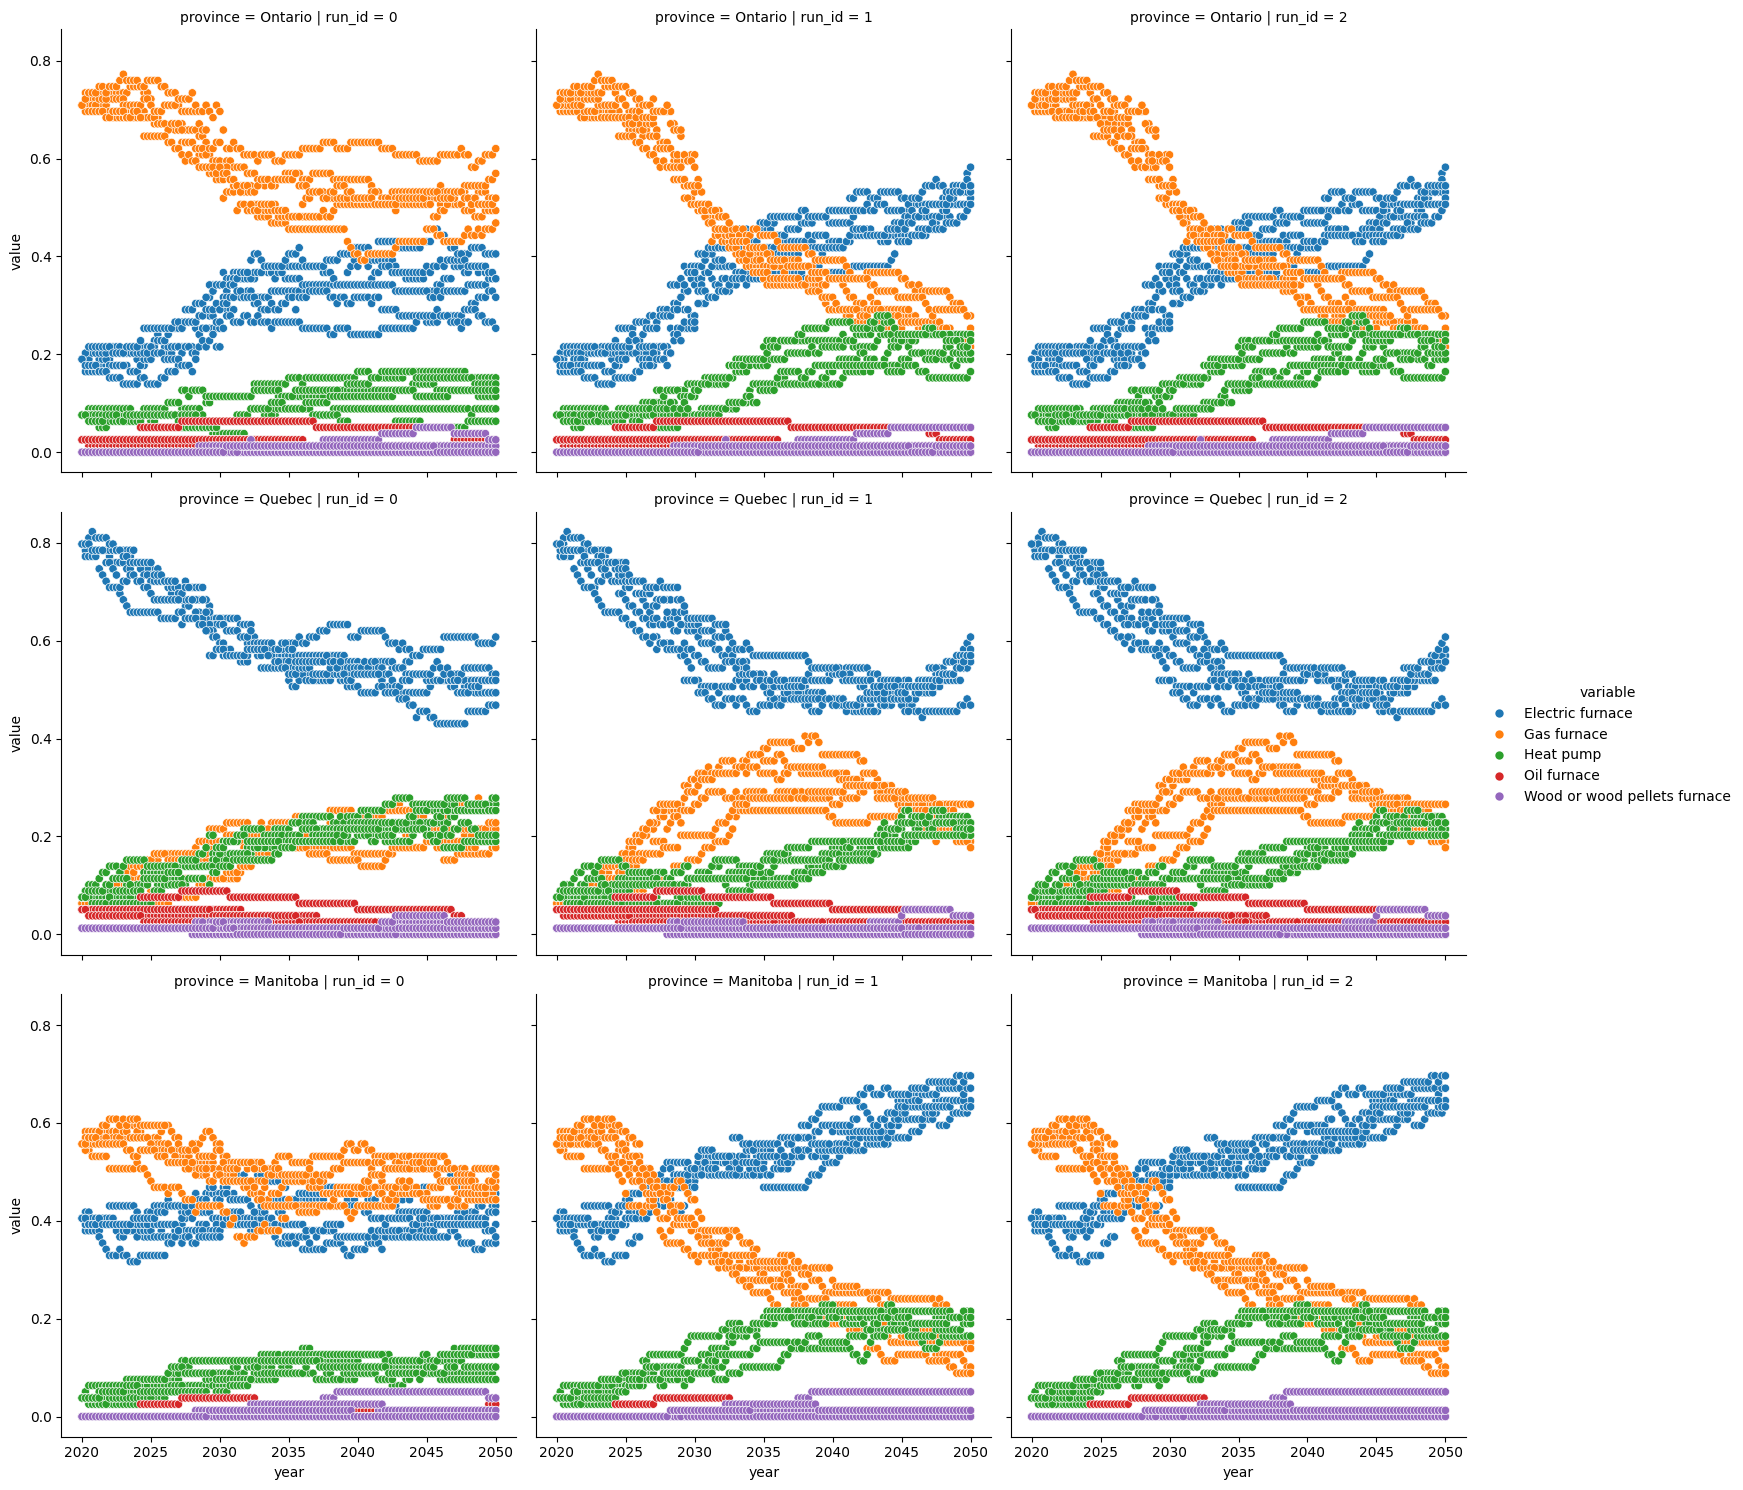

In [11]:
import seaborn as sns

sns.relplot(long_tech_shares, x="year", y="value", hue="variable", col="run_id", row="province") # kind="line",

In [5]:
import pickle
carrier_demands = []
for run_id, result_dir in enumerate(abm_result_dirs):
    df = pickle.load(result_dir.joinpath("mean_carrier_demand.pkl").open("rb"))
    df["run_id"] = run_id
    carrier_demands.append(df)

abm_demands = pd.concat(carrier_demands)

abm_demands.head()

Electricity     Natural gas Heating oil  \
province year   hour                                               
Manitoba 2020.0 0     1005888.018332  1490181.707271         0.0   
                1      1010834.04332  1497509.039763         0.0   
                2      1018665.24955  1509110.649543         0.0   
                3      1026614.21828   1520886.71962         0.0   
                4     1039725.109914  1540309.966068         0.0   

                     Wood or wood pellets  run_id  
province year   hour                               
Manitoba 2020.0 0                     0.0       0  
                1                     0.0       0  
                2                     0.0       0  
                3                     0.0       0  
                4                     0.0       0

In [17]:
import plotly.express as px
annual_demands = abm_demands.groupby(["year", "run_id","province"]).sum().reset_index().melt(id_vars=["year","run_id","province"])
annual_demands
# no effect after first change?
fig = px.line(annual_demands, x="year",y="value",color="variable", facet_col="run_id", template="plotly",facet_row="province")
def split_annotation(annot, must_contain="province"):
    if must_contain in annot.text:
        annot.text = annot.text.split("=")[-1]
fig.for_each_annotation(split_annotation)

## COPPER electricity prices over iterations

In [7]:
from main import get_copper_el_prices
import toml
config_path = "copper/scenarios/BAU_scenario/config.toml"
config = toml.load(config_path)


In [8]:
el_prices_list = []
for run_id, result_dir in enumerate(copper_result_dirs):
    prices = get_copper_el_prices(config)
    prices["run_id"] = run_id
    el_prices_list.append(prices)

el_price_df = pd.concat(el_prices_list)

n_days: 1, using run_days_test: [2]
n_days: 1, using run_days_test: [2]
n_days: 1, using run_days_test: [2]


In [14]:
el_price_df = el_price_df.groupby(["year","hour","province","run_id"]).mean()
el_price_df

dual_price
year hour province run_id            
2025 25   Manitoba 0         2.263740
                   1         2.263740
                   2         2.263740
          Ontario  0        10.598543
                   1        10.598543
...                               ...
2050 48   Ontario  1         0.001602
                   2         0.001602
          Quebec   0         0.000381
                   1         0.000381
                   2         0.000381

[1296 rows x 1 columns]

In [16]:
import plotly.express as px

px.line(el_price_df.reset_index(), x="hour", y="dual_price", facet_col="year", facet_row="run_id", color="province", template="plotly")